In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from __future__ import print_function
from numpy import *
from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
from salishsea_tools import visualisations as vis
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
import datetime as dt

%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## code to create an array of paths to netcdfs

In [4]:
def make_nclen(start,end,ftype, sdir):
    date_ar = []
    sens_ar = []
    doy_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        dddd = tdate.format('DDDD')
        nc_sens = sdir + '/SKOG_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        tnc_sens = glob.glob(nc_sens)
        sens_ar.append(tnc_sens[0])
        date_ar.append(ddmmmyy)
        doy_ar.append(dddd)
    return date_ar, sens_ar, doy_ar

## wrapper code for mocsy

    make 1d arrays out of model fields, convert some quantities to appropriate units

In [5]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]
    size_2 = size_box[2]


    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)
    print('beginning mocsy')
    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    print('finished mocsy')

    pHr = pH.reshape(size_0,size_1,size_2)
    OmAr = OmegaA.reshape(size_0,size_1,size_2)
    pco2r = pco2.reshape(size_0,size_1,size_2)
    
    return pHr, OmAr, pco2r

## make_avgthwg_plot_OmA

    -takes  two starting, ending date strings
    -tak
    

In [6]:
def make_avgthwg_plot_OmA(start,end,sdir_PI, sdir_BR, figstr):
    
    #extract months, days, years from initial date string
    #(I can see Doug wouldn't like this) - hacky but multi-functional

    yr_s = int(start[0:4])
    mon_s = int(start[5:7])
    day_s = int(start[8:10])

    yr_e = int(end[0:4])
    mon_e = int(end[5:7])
    day_e = int(end[8:10])

    st = dt.datetime(yr_s,mon_s,day_s)
    en = dt.datetime(yr_e,mon_e,day_e)
    
    y_st = st.timetuple().tm_yday
    print(y_st)
    y_en = en.timetuple().tm_yday
    print(y_en)
    ts_BR = np.arange(y_st,y_en+1,1)
    days_in = len(ts_BR)

    #extract files for carbon and temp/sal model results
    dates_preind_carp, files_preind_carp, doy_preind = make_nclen(start,end,'carp', sdir_PI)
    dates_br_carp, files_br_carp, doy_br = make_nclen(start,end,'carp', sdir_BR)
    dates_preind_grid, files_preind_grid, doy_preind = make_nclen(start,end,'grid_T', sdir_PI)
    dates_br_grid, files_br_grid, doy_br = make_nclen(start,end,'grid_T', sdir_BR)
    
    #create array of appropriate depths
    dfile = nc.Dataset('/data/tjarniko/results/BASERUN_EXP/PI_3rd_2015/ncs/SKOG_1d_20150101_20150301_carp_T_20150101-20150101.nc')
    depths = dfile['deptht'][:]
    depth_broad = np.zeros([1,40,898,398])
    depth_broad2 = np.zeros([1,898,398])

    for i in range(0,40):
        depth_broad2[:] = depths[i]
        depth_broad[:,i,:,:] = depth_broad2

    #initialize empty arrays for relevant variables
    mon3_dic_BR = np.zeros([days_in,40,898,398])
    mon3_dic_PI = np.zeros([days_in,40,898,398])
    mon3_ta_BR = np.zeros([days_in,40,898,398])
    mon3_ta_PI = np.zeros([days_in,40,898,398])
    mon3_temp_BR = np.zeros([days_in,40,898,398])
    mon3_temp_PI = np.zeros([days_in,40,898,398])
    mon3_sal_BR = np.zeros([days_in,40,898,398])
    mon3_sal_PI = np.zeros([days_in,40,898,398])
    mon3_OmA_BR = np.zeros([days_in,40,898,398])
    mon3_OmA_PI = np.zeros([days_in,40,898,398]) 
    
    #sequentially cycle through netcdfs, open them, calculate mocsy parameters

    for i in range (0,days_in):
        
        if i%5 ==0:
            print(i)
        test_br_carp = nc.Dataset(files_br_carp[i])
        test_pi_carp = nc.Dataset(files_preind_carp[i])
        test_br_grid = nc.Dataset(files_br_grid[i])
        test_pi_grid = nc.Dataset(files_preind_grid[i])
        t_dic_br = np.squeeze(test_br_carp['dissolved_inorganic_carbon'][:])
        t_dic_pi = np.squeeze(test_pi_carp['dissolved_inorganic_carbon'][:])
        t_ta_br = np.squeeze(test_br_carp['total_alkalinity'][:])
        t_ta_pi = np.squeeze(test_pi_carp['total_alkalinity'][:])
        t_sal_br = np.squeeze(test_br_grid['vosaline'][:])
        t_sal_pi = np.squeeze(test_pi_grid['vosaline'][:])        
        t_temp_br = np.squeeze(test_br_grid['votemper'][:])
        t_temp_pi = np.squeeze(test_pi_grid['votemper'][:])  
        
        #this assignment is no longer necessary - I would 
        mon3_dic_BR[i,:,:,:] = t_dic_br
        mon3_dic_PI[i,:,:,:] = t_dic_pi
        mon3_ta_BR[i,:,:,:] = t_ta_br
        mon3_ta_PI[i,:,:,:] = t_ta_pi
        mon3_sal_BR[i,:,:,:] = t_sal_br
        mon3_sal_PI[i,:,:,:] = t_sal_pi
        mon3_temp_BR[i,:,:,:] = t_temp_br
        mon3_temp_PI[i,:,:,:] = t_temp_pi
        
        #calculate mocsy for each day for each field
        pHr_pi, OmAr_pi, pco2r_pi = oned_moxy(t_sal_pi, t_temp_pi, t_dic_pi, t_ta_pi, 1, depth_broad)
        pHr_br, OmAr_br, pco2r_br = oned_moxy(t_sal_br, t_temp_br, t_dic_br, t_ta_br, 1, depth_broad)
        
        #
        mon3_OmA_BR[i,:,:,:] = OmAr_br
        mon3_OmA_PI[i,:,:,:] = OmAr_pi
        
    mon3_OmA_BR_m = np.ma.masked_where(mon3_OmA_BR >= 1e10, mon3_OmA_BR)
    mon3_OmA_PI_m = np.ma.masked_where(mon3_OmA_PI >= 1e10, mon3_OmA_PI)
    OmAr_pi_av = np.mean(mon3_OmA_PI_m,axis = 0)
    OmAr_br_av = np.mean(mon3_OmA_BR_m,axis = 0)
    
    bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
    mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

    t_cmap = cm.cm.balance
    t_vmin = 0
    t_vmax = 2
    stepsize = 0.01
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
    vis.contour_thalweg(ax1, OmAr_br_av, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax1.set_title('BASE RUN 2015, averaged OmA: '+start+' - '+end , fontsize = 16)

    t_cmap = cm.cm.balance
    t_vmin = 0
    t_vmax = 2
    stepsize = 0.01
    vis.contour_thalweg(ax2, OmAr_pi_av, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax2.set_title('PREINDUSTRIAL RUN 2015, averaged OmA: '+start+' - '+end , fontsize = 16)

    t_cmap = cm.cm.balance
    t_vmin = -0.3
    t_vmax = 0.3
    stepsize = 0.005
    vis.contour_thalweg(ax3, OmAr_br_av - OmAr_pi_av, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax3.set_title('BASE - PREINDUSTRIAL RUN 2015, averaged OmA: '+start+' - '+end, fontsize = 16)
    
    fig.tight_layout()
    plt.show()
    fig.savefig(figstr)
    
    return mon3_OmA_BR, mon3_OmA_PI, days_in

In [7]:
start1 = '2015-01-01'
end1 = '2015-01-03'

sdir_preind = '/data/tjarniko/results/BASERUN_EXP/PI_3rd_2015/ncs/'
sdir_br = '/data/tjarniko/results/BASERUN_EXP/BR_2nd_2015/ncs/'
ncname = 'Jan3d_OmA.nc'

mon3_OmA_BR, mon3_OmA_PI, days_in = make_avgthwg_plot_OmA(start1,end1,sdir_preind, sdir_br, 'Jan5d_Oma.png')

1
3
0
beginning mocsy
finished mocsy
beginning mocsy
finished mocsy
beginning mocsy
finished mocsy
beginning mocsy
finished mocsy
beginning mocsy
finished mocsy
beginning mocsy
finished mocsy


/ocean/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/visualisations.py:206: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


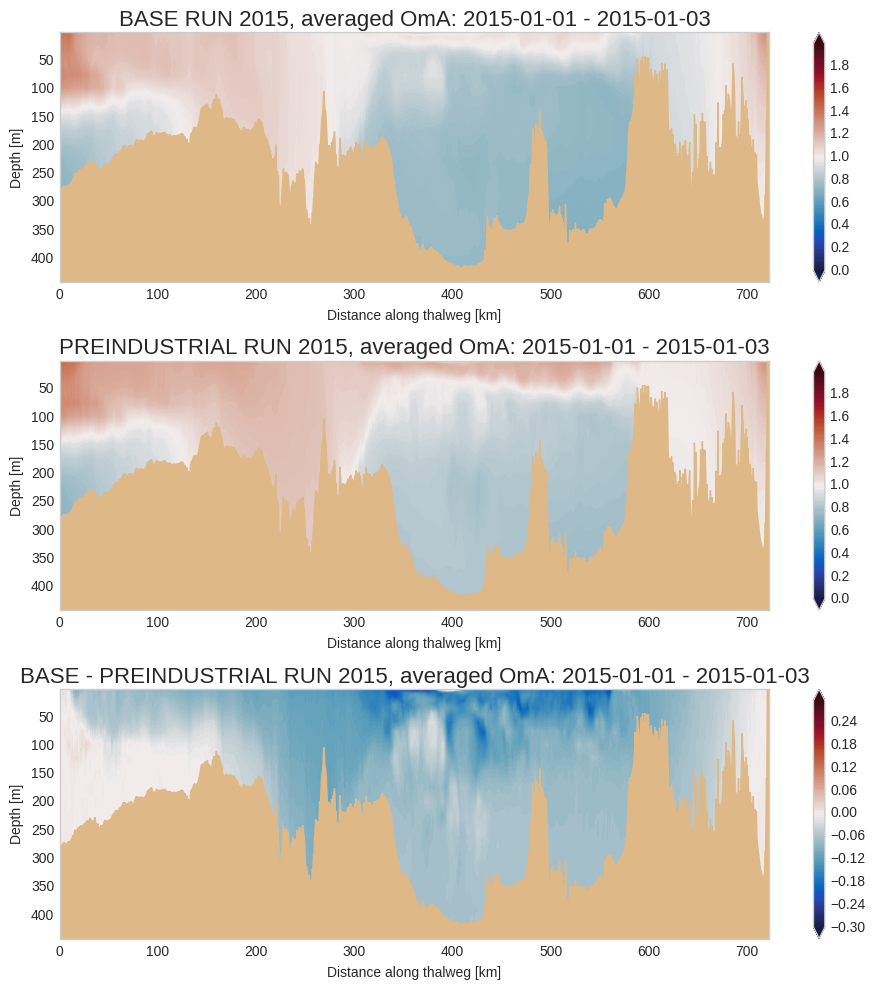

In [8]:
mon3_OmA_BR, mon3_OmA_PI, days_in = make_avgthwg_plot_OmA(start1,end1,sdir_preind, sdir_br, 'Jan5d_Oma.png')

In [10]:
mon3_OmA_BR_m = np.ma.masked_where(mon3_OmA_BR >= 1e10, mon3_OmA_BR)
mon3_OmA_PI_m = np.ma.masked_where(mon3_OmA_PI >= 1e10, mon3_OmA_PI)

In [12]:
f = nc.Dataset(ncname,'w', format='NETCDF4') #'w' stands for write
g = f.createGroup('model_output')
#g.createDimension('days', len(NO3_mod))
g.createDimension('days', days_in)
g.createDimension('depths', 40)
g.createDimension('ys', 898)
g.createDimension('xs', 398)
ts = g.createVariable('OmAr_pi','f4',('days','depths','ys','xs'))
ts[:] = mon3_OmA_PI_m
ts2 = g.createVariable('OmAr_br','f4',('days','depths','ys','xs'))
ts2[:] = mon3_OmA_BR_m
f.close()